In [78]:
import pyfits
from scipy.ndimage import gaussian_filter
import scipy.optimize as opt
import numpy as np
import pylab as plt
import rydlab
import pandas as pd
from fitting2d import Fit2d2Gaussian
import os
import copy
from lmfit import Model
from lmfit.models import LorentzianModel
pd.options.display.max_colwidth = 120

import seaborn as sns
sns.set_style("darkgrid")
import matplotlib as mpl
mpl.rc('image', cmap='afmhot')

file_date = '2019-06-05'
path = 'A:/Projekte - Projects/2019_IEI/July/02'
folders = rydlab.analyze_folder(path,filter=0)
folders

Name  \
0                                 A:/Projekte - Projects/2019_IEI/July/02\EITshift   
1                 A:/Projekte - Projects/2019_IEI/July/02\EITshift_averaged_images   
2                          A:/Projekte - Projects/2019_IEI/July/02\dummyscanblue01   
3          A:/Projekte - Projects/2019_IEI/July/02\dummyscanblue01_averaged_images   
4                              A:/Projekte - Projects/2019_IEI/July/02\scanblueres   
5              A:/Projekte - Projects/2019_IEI/July/02\scanblueres_averaged_images   
6                  A:/Projekte - Projects/2019_IEI/July/02\scanblueresonance_FINAL   
7  A:/Projekte - Projects/2019_IEI/July/02\scanblueresonance_FINAL_averaged_images   
8                                  A:/Projekte - Projects/2019_IEI/July/02\tofscan   

   Valid  
0   True  
1  False  
2   True  
3  False  
4   True  
5  False  
6   True  
7  False  
8   True

In [79]:
path=folders.Name[3]

os.chdir(path)

variables = np.loadtxt( '2019-06-05_variables.dat' )[:,1]
N = len(variables)
print(os.getcwd())

def fitsopen(n,bg):
    if n<10:
        hdulist = pyfits.open(file_date+str("_")+str(0)+str(n)+'.fts')
    else:
        hdulist = pyfits.open(file_date+str("_")+str(n)+'.fts')

    data=np.zeros((90,400))

    for y in range(10,100):
        for x in range(10,410):
            data[y-10,x-10]=-np.log((hdulist[0].data[0,y,x]-hdulist[0].data[2,y,x])/(hdulist[0].data[1,y,x]-hdulist[0].data[2,y,x]))

    hdulist.close()
    return gaussian_filter(data-bg, 1, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)

def fitsopen_bg(n,bg):
    hdulist = pyfits.open(file_date+str("_")+str(n).zfill(2)+'.fts')
    images = hdulist[0].data
    no_absorb = images[0]
    absorb = images[1]
    div = (no_absorb-bg)/(absorb-bg)
    
    div = div[10:100,10:410]
    div = -np.log(div)
    div = np.nan_to_num(div)
    return div

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                        + c*((y-yo)**2)))
    return g.flatten()


def two_Gaussian(xy_mesh, amplitude1, xo1, yo1, sigma_x1, sigma_y1, theta1, amplitude2, xo2, yo2, sigma_x2, sigma_y2, theta2, offset):
    (x, y) = xy_mesh
    xo1 = float(xo1)
    yo1 = float(yo1)
    xo2 = float(xo2)
    yo2 = float(yo2)

    a1 = (np.cos(theta1)**2)/(2*sigma_x1**2) + (np.sin(theta1)**2)/(2*sigma_y1**2)
    b1 = -(np.sin(2*theta1))/(4*sigma_x1**2) + (np.sin(2*theta1))/(4*sigma_y1**2)
    c1 = (np.sin(theta1)**2)/(2*sigma_x1**2) + (np.cos(theta1)**2)/(2*sigma_y1**2)
    a2 = (np.cos(theta2)**2)/(2*sigma_x2**2) + (np.sin(theta2)**2)/(2*sigma_y2**2)
    b2 = -(np.sin(2*theta2))/(4*sigma_x2**2) + (np.sin(2*theta2))/(4*sigma_y2**2)
    c2 = (np.sin(theta2)**2)/(2*sigma_x2**2) + (np.cos(theta2)**2)/(2*sigma_y2**2)

    g = offset + amplitude1*np.exp( - (a1*((x-xo1)**2) + 2*b1*(x-xo1)*(y-yo1) + c1*((y-yo1)**2))) + amplitude2*np.exp( - (a2*((x-xo2)**2) + 2*b2*(x-xo2)*(y-yo2) + c2*((y-yo2)**2)))

    return g.flatten()


def make_background(N):
    list_bg=list()
    for n in range(0,N):
        hdulist = pyfits.open(file_date+str("_")+str(n).zfill(2)+'.fts')
        list_bg.append(hdulist[0].data[2])
        hdulist.close()
    bg_mean = np.array(list_bg).mean(axis=0)
    bg_std = np.array(list_bg).std(axis=0)
    return bg_mean,bg_std
        

def lorentz(x_array,gamma,xoo,a,o):
    xoo = float(xoo)
    gamma = float(gamma)
    x=x_array
    #print(x)
    #print(type(x))
    #l=gamma/((2*np.pi)((x-xoo)**2 + (gamma/2)**2))
    l=a*gamma/( (x-xoo)**2 + (gamma/2)**2 )+o
    #print(l)
    #print(type(l))
    return l#/(2*np.pi)



model_twoG = Model(two_Gaussian)
from lmfit import Parameters
params = Parameters()

params = model_twoG.make_params()

# cloud distribution
params.add('amplitude1',value=0.0)
params.add('yo1',value=160,min=140,max=180)
params.add('xo1',value=45,min=30,max=60)
params.add('sigma_x1',value=5,min=20,max=200)
params.add('sigma_y1',value=5,min=20,max=200)
params.add('theta1',value=0,min=0,max=np.pi)

# EIT/Autler-Townes-dip
params.add('amplitude2',value=0.00)
params.add('yo2',value=171.2,min=168,max=175)
params.add('xo2',value=48.1,min=46,max=50)
params.add('sigma_x2',value=10,min=3,max=15)
#params.add('sigma_y2',value=10,min=3,max=15)
params.add('sigma_y2',expr='sigma_x2')
params.add('theta2',value=0,min=0,max=np.pi)

# offset
params.add('offset',value=0)
bg_mean,bg_std = make_background(N)
#image = fitsopen_bg(n,bg_mean)
#image
#plt.imshow(image)
print(np.shape(bg_mean))

A:\Projekte - Projects\2019_IEI\July\02\dummyscanblue01_averaged_images


C:\Users\Control_Computer\AppData\Local\conda\conda\envs\rydlab\lib\site-packages\pyfits\util.py:899: UserWarning:

Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.



(100, 512)


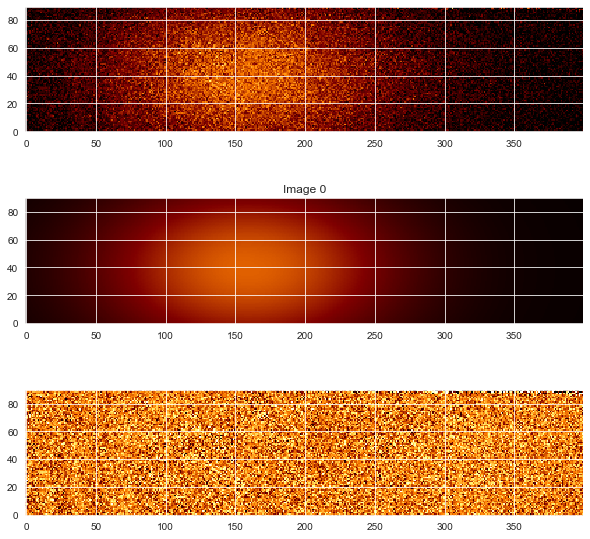

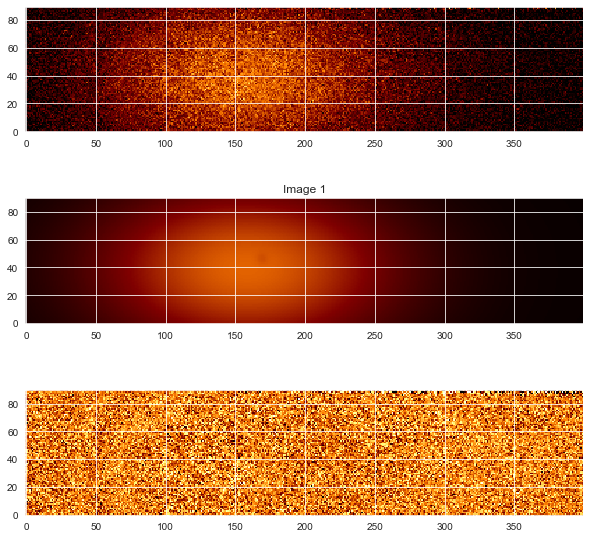

C:\Users\Control_Computer\AppData\Local\conda\conda\envs\rydlab\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning:

invalid value encountered in log



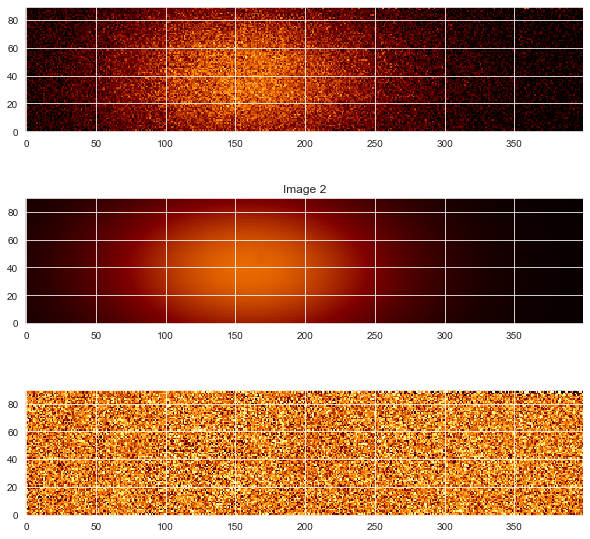

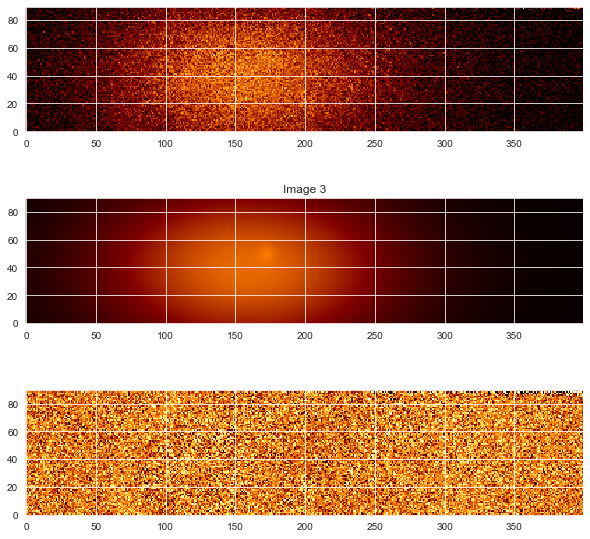

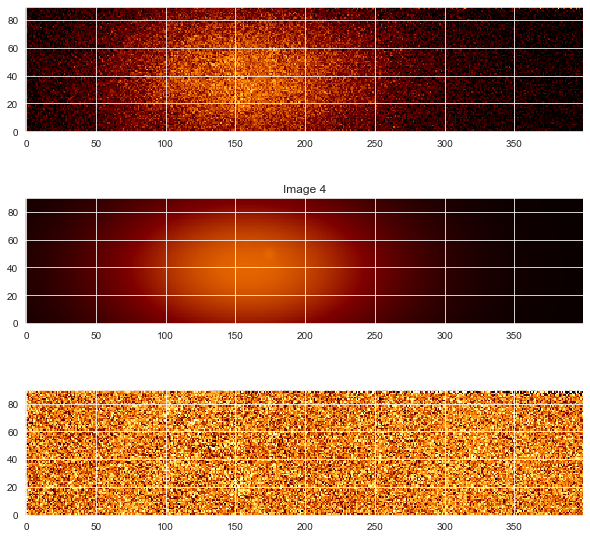

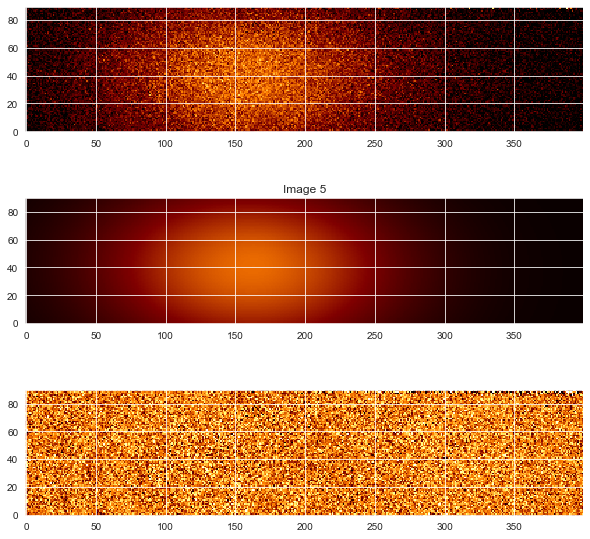

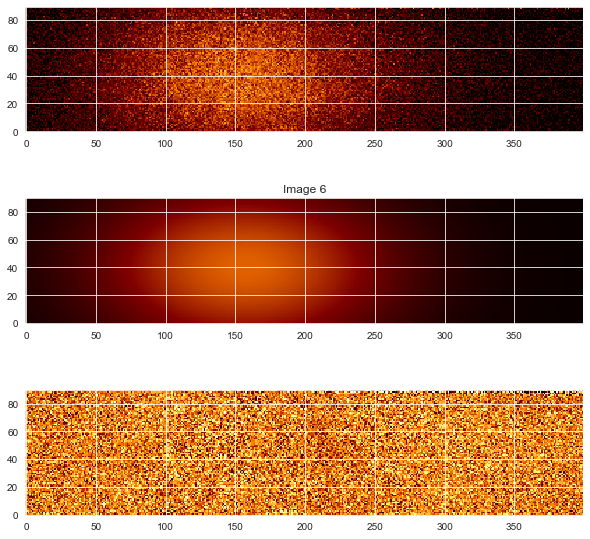

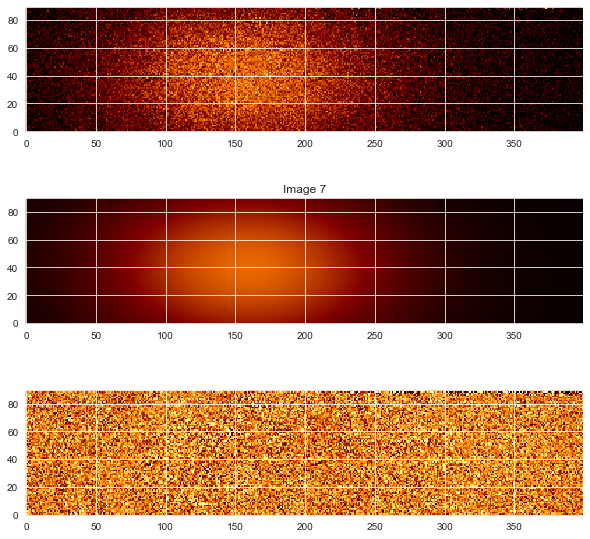

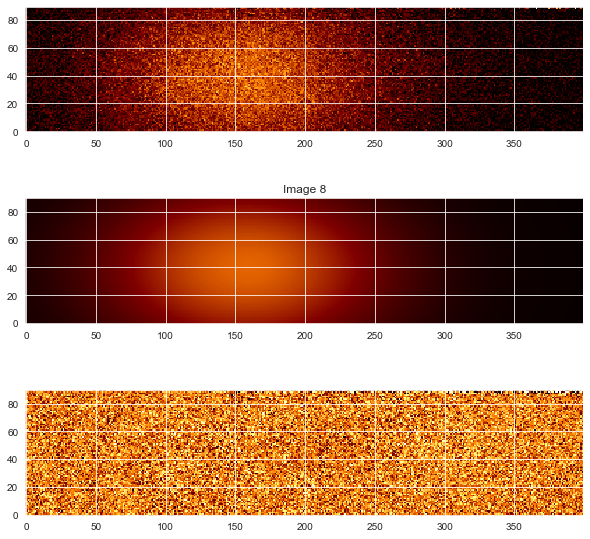

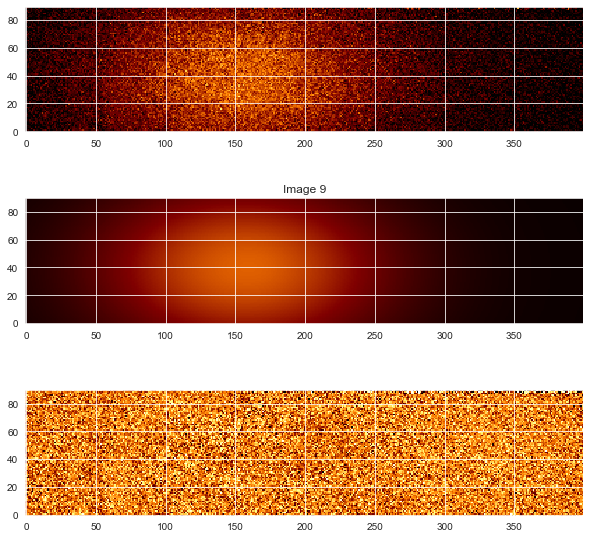

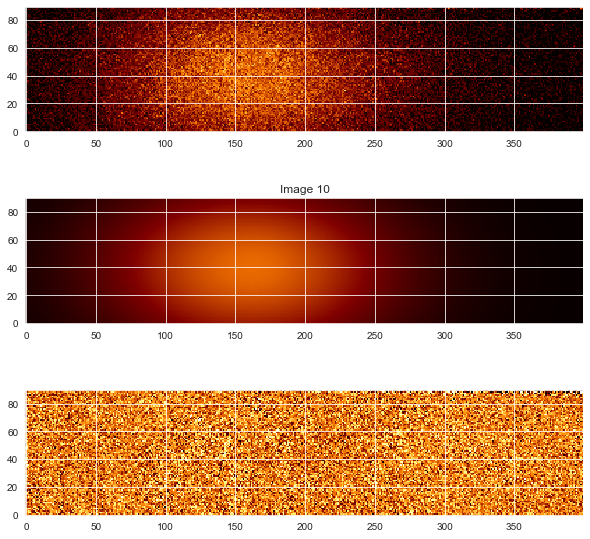

C:\Users\Control_Computer\AppData\Local\conda\conda\envs\rydlab\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning:

divide by zero encountered in true_divide



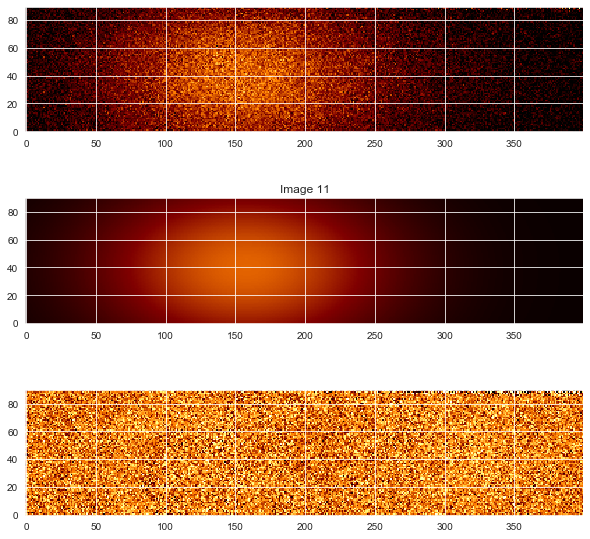

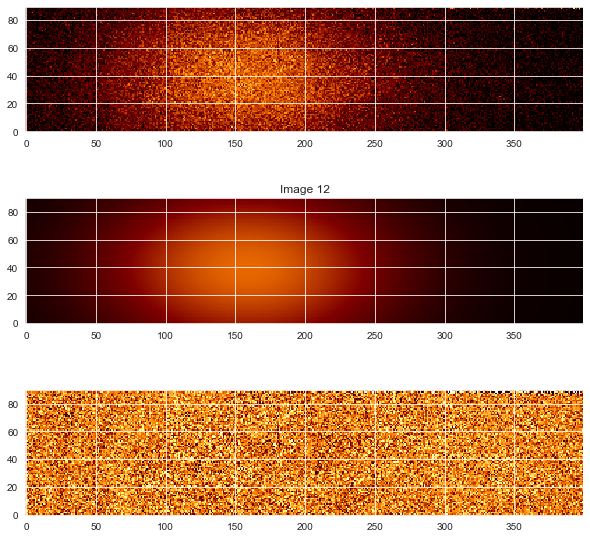

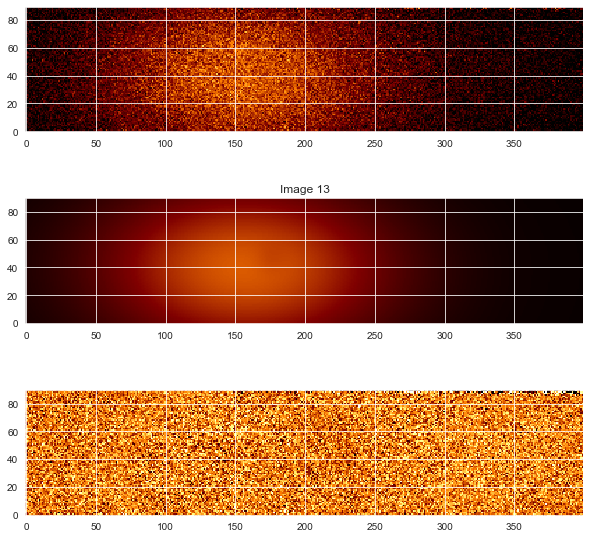

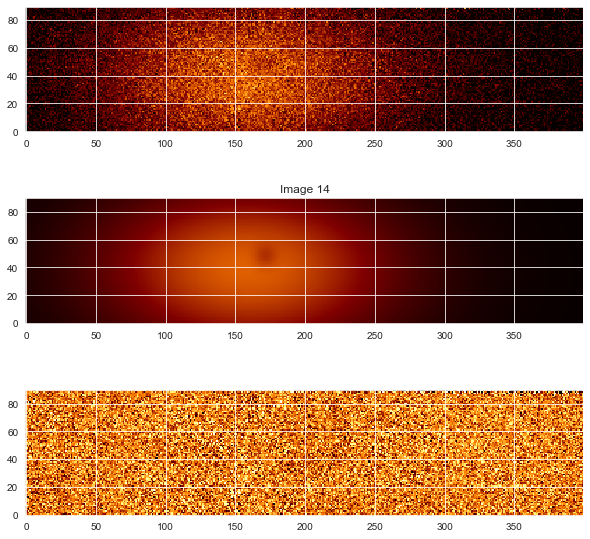

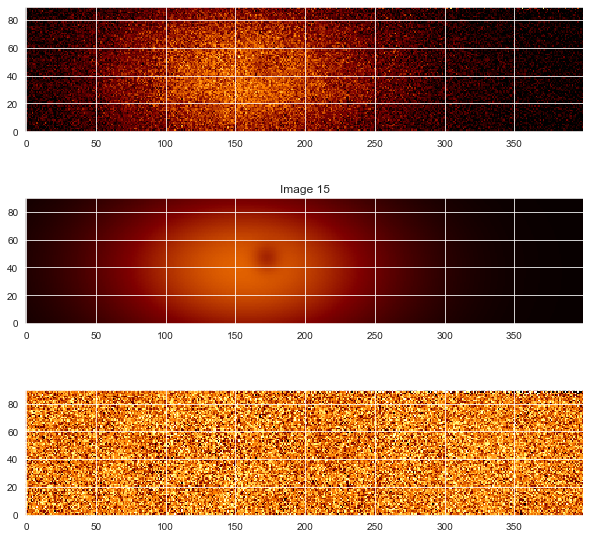

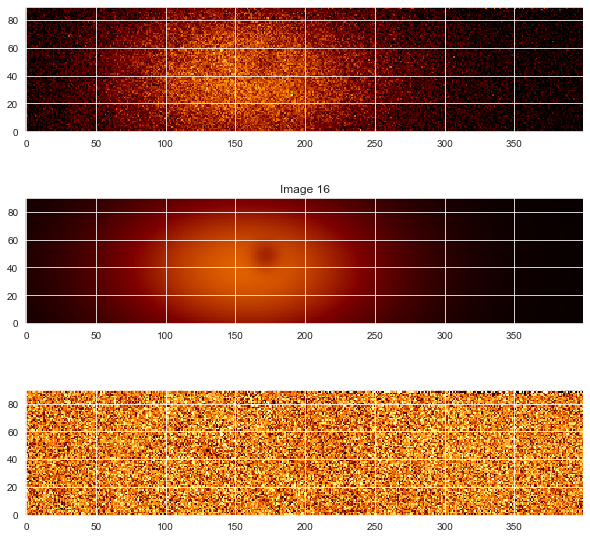

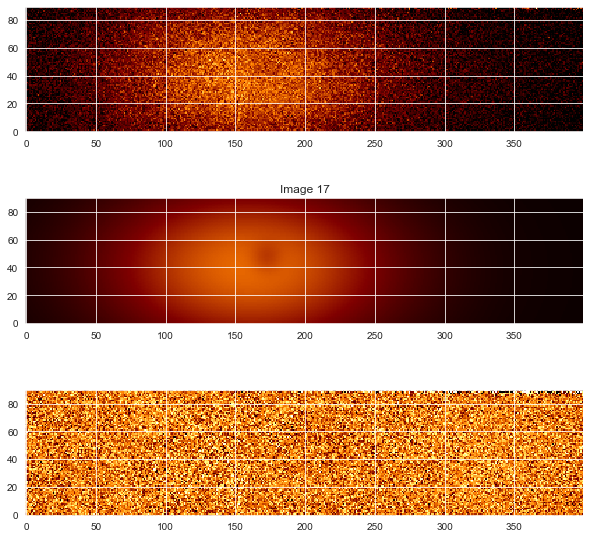

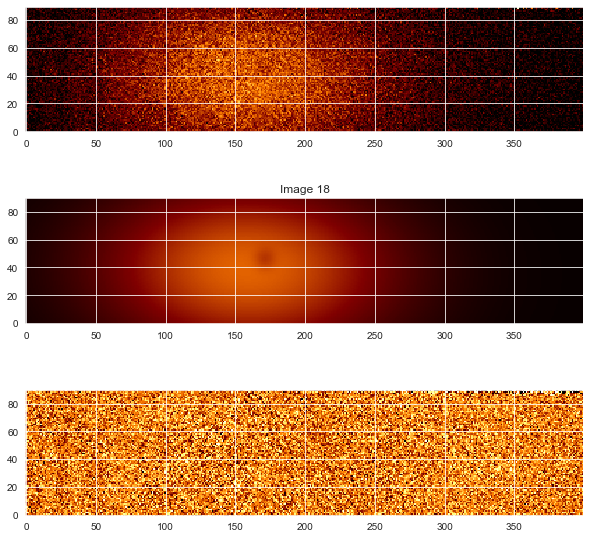

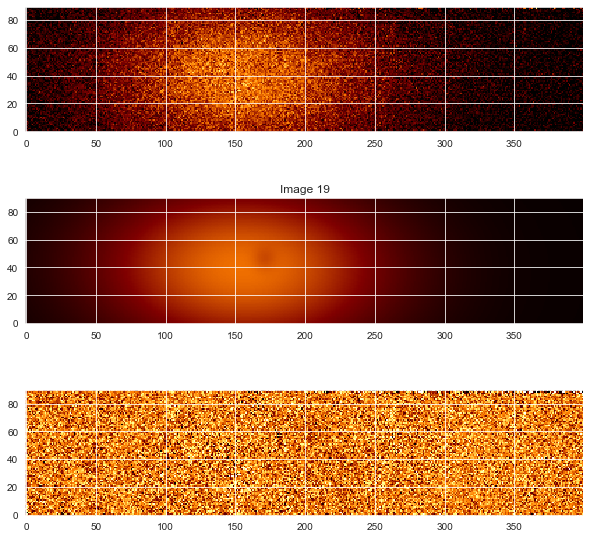

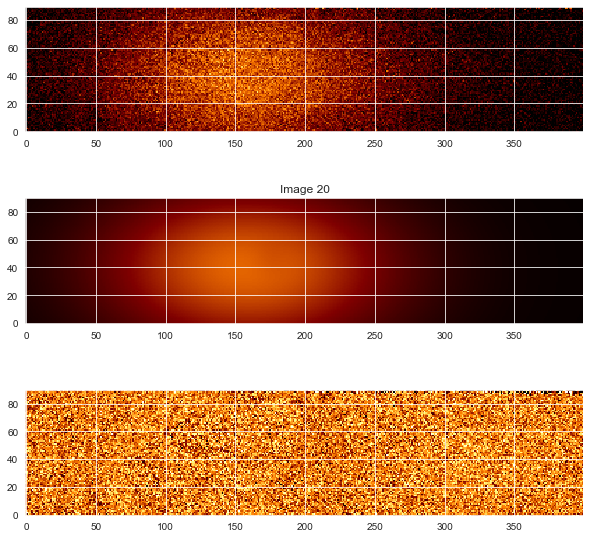

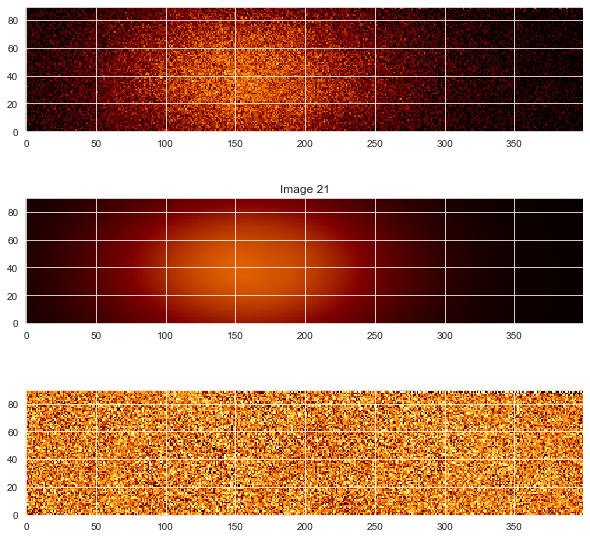

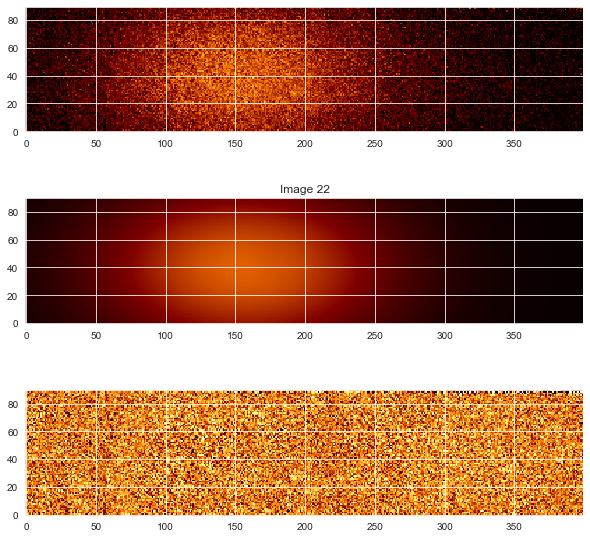

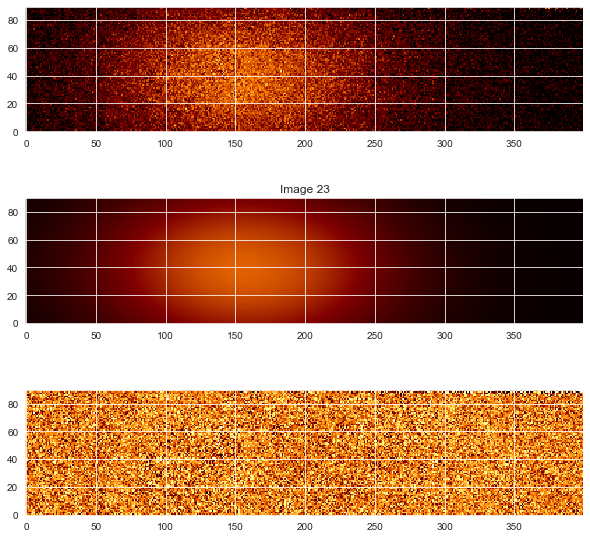

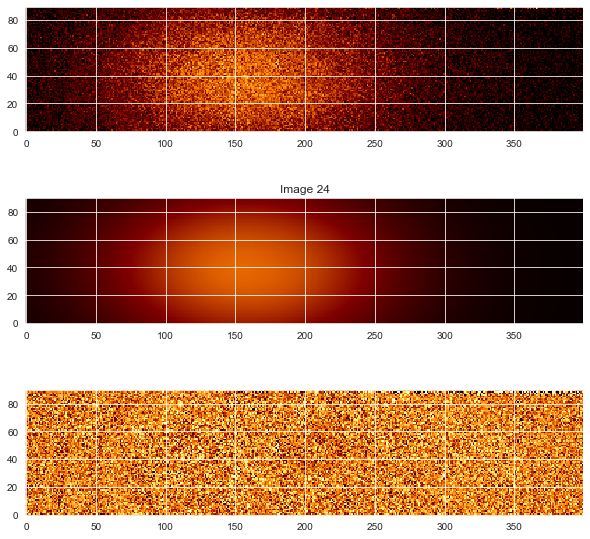

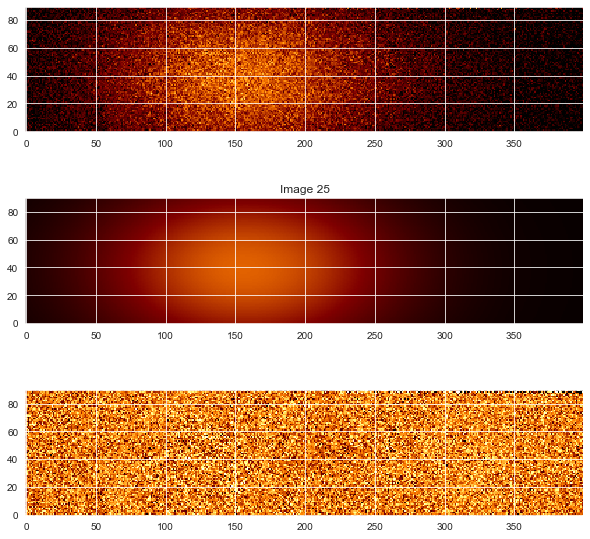

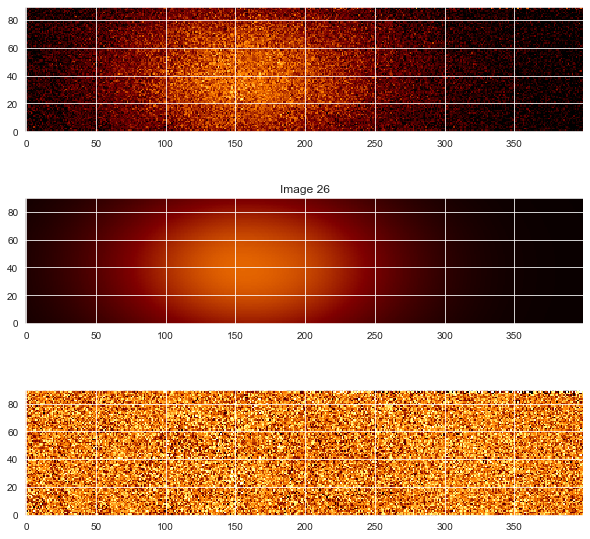

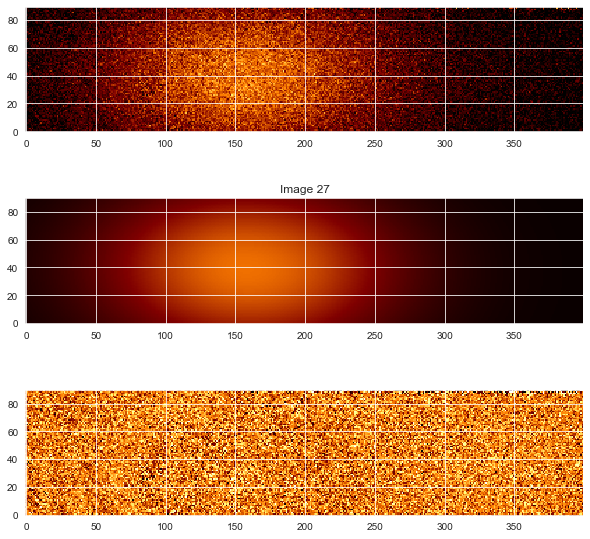

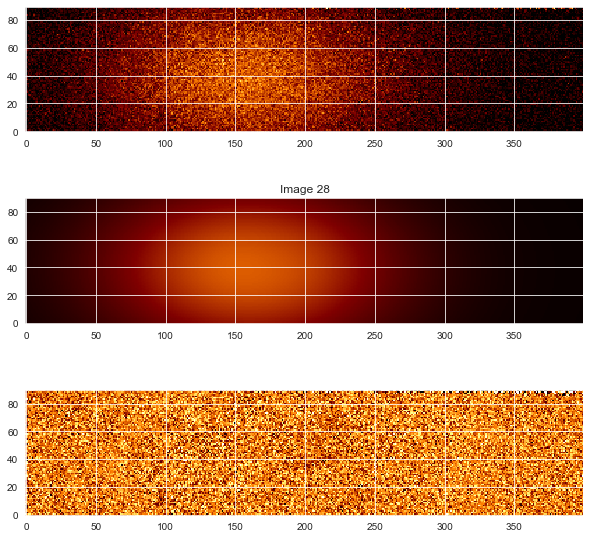

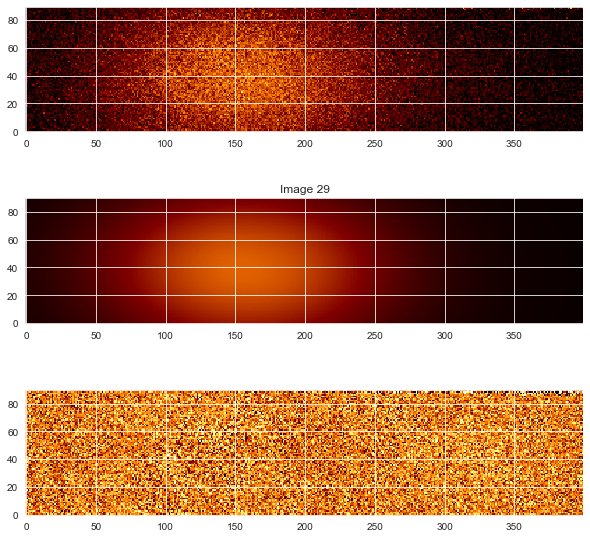

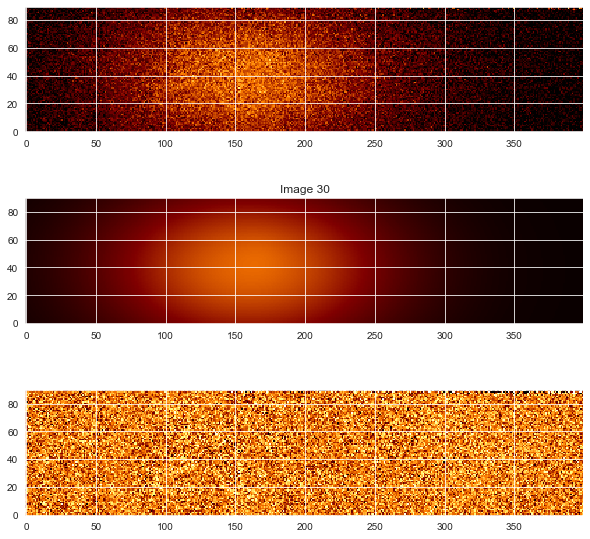

In [80]:
results=list()
for n in range(0,len(variables)):
    bg,std= make_background(N)
    image = fitsopen_bg(n,bg)
    #image =  gaussian_filter(image, 1, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)
    shape = image.shape
    x,y = np.mgrid[0:shape[0],0:shape[1]]
    image_flat=image.flatten()    
    out = model_twoG.fit(image_flat,params,xy_mesh=(x,y))##method='Powel')
    fig,ax = plt.subplots(3,1,figsize=(10,10))
    results.append(copy.deepcopy(out))
    params = out.params
    params.add('amplitude2',value=0.00)
    ax[0].imshow(image,
                 origin='bottom',vmin=0, vmax=0.8)
    ax[1].set_title('Image '+str(n))
    ax[1].imshow(out.best_fit.reshape(shape),
                 origin='bottom',vmin=0, vmax=0.8)
    ax[2].imshow((image-out.best_fit.reshape(shape)),
                 origin='bottom',vmin=-0.2, vmax=0.2)
    plt.show()

In [103]:
p = results[0].params['yo1']



def AutlerTownesIm(Dp,Dp0=0,Dc=0,g31=0.3,g21=0.1,Wc=0.5,y0=0.2,y1=0,offset=0):
    """
    Imaginary Part of the first order susceptibility
    
    in the ladder scheme:
    index 1 ~ ground state
    index 2 ~ Rydberg state
    index 3 ~ intermediate state
    
    
    """
    
    Dp = Dp-Dp0
    d = Dp-Dc
    return offset+(y0+y1*Dp)*( 8*d**2 * g31 + 2*g21*(abs(Wc)**2 + g21*g31)) / abs(abs(Wc)**2 + (g31+1.j*2*Dp)*(g21+1.j*2*d))**2

model_AT = Model(AutlerTownesIm)
params = model_AT.make_params()
params.add('Dc',value=0)#,vary=False)
params.add('g31',value=1,min=0,max=8,vary=False)
params.add('g21',value=0.001,min=0,max=0.01)
params.add('Wc',value=0,min=0,max=1)
params.add('y0',value=0.8)
params.add('y1',value=1)
params.add('offset',value=0.00)

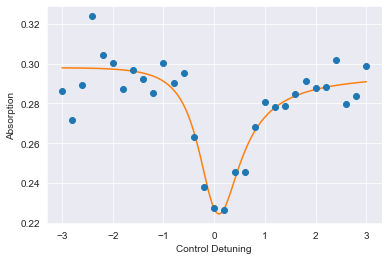

In [104]:
y = [1-np.e**(-r.params['amplitude2'].value-r.params['amplitude1'].value) for r in results]
#yerr = np.sqrt([ (r.params['amplitude2'].stderr/r.params['amplitude2'].value)**2+(r.params['amplitude1'].stderr/r.params['amplitude1'].value)**2 
#        if (r.params['amplitude2'].stderr is not None) & (r.params['amplitude2'].stderr is not None) else 0 for r in results ])

yerr = np.sqrt([ (r.params['amplitude2'].stderr)**2+(r.params['amplitude1'].stderr)**2 + (r.params['offset'].stderr)**2 if (r.params['amplitude2'].stderr is not None) & (r.params['amplitude2'].stderr is not None) & (r.params['offset'].stderr is not None) else 0 for r in results ])
#yerr=np.array(yerr)*y
plt.errorbar(variables,y,yerr=yerr,marker='o',linestyle='')

out = model_AT.fit(y,params=params,Dp=variables )

#popt1, pcov1 = opt.curve_fit(lorentz,variables,y, p0=(2.5,1.,-0.13,0.1))

#plt.plot(variables,lorentz(np.array(variables), *popt1))
v = np.linspace(min(variables),max(variables),200)
#plt.plot(variables,out.init_fit)
plt.plot(v,model_AT.eval(out.params,Dp=v))

#y = [1-np.exp(-r.params['amplitude1'].value) for r in results]

#model = LorentzianModel()
#lor_fit = model.fit(y,x=variables)
#lor_fit.plot_fit()
plt.xlabel("Control Detuning")
plt.ylabel("Absorption")
plt.savefig("AT.svg")
plt.show()
#n = np.argmax(-np.array(valdiv))

### Fit amplitude 1

In [89]:
results[20]

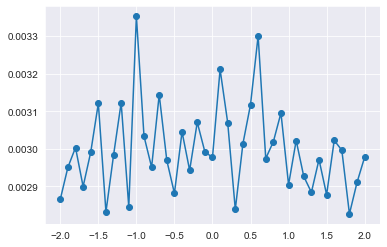

In [7]:
out.result
y = [ r.redchi for r in results]

plt.plot(variables,y,'o-')

#y = [ r. for r in results]

#plt.plot(variables,y,marker='o',linestyle='')

In [8]:
r = results[0]

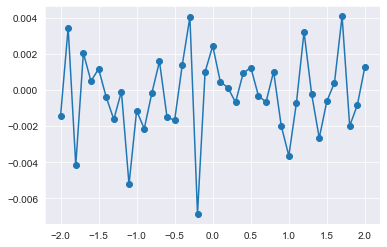

In [22]:
y = np.array([r.residual.reshape(shape)[40:60,160:180].mean() for r in results])
plt.plot(variables,1-np.exp(-y),'o-')


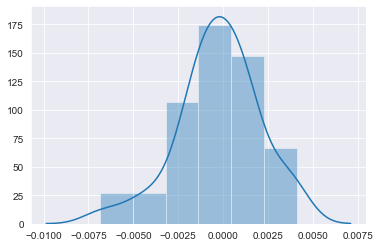

In [23]:
sns.distplot(y,bins=6)

In [17]:
out.params.pretty_print()

Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
Dc        0.5829     -inf      inf    0.253     True     None     None
Dp0      0.03538     -inf      inf   0.1957     True     None     None
Wc         1.491        0      inf  0.07508     True     None     None
g21       0.3837        0      inf   0.1054     True     None     None
g31        3.004        2       10    0.589     True     None     None
offset    0.1567     -inf      inf   0.0207     True     None     None
y0        0.1956     -inf      inf  0.06509     True     None     None
y1       0.03599     -inf      inf  0.01467     True     None     None
